In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d colearninglounge/predicting-pulsar-starintermediate

Dataset URL: https://www.kaggle.com/datasets/colearninglounge/predicting-pulsar-starintermediate
License(s): CC-BY-NC-SA-4.0
  0% 0.00/790k [00:00<?, ?B/s]
100% 790k/790k [00:00<00:00, 75.3MB/s]


In [3]:
!unzip /content/predicting-pulsar-starintermediate.zip

Archive:  /content/predicting-pulsar-starintermediate.zip
  inflating: pulsar_data_test.csv    
  inflating: pulsar_data_train.csv   


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
train = pd.read_csv("/content/pulsar_data_train.csv")
test = pd.read_csv("/content/pulsar_data_test.csv")
train.columns = [x.strip() for x in train.columns]
test.columns = [x.strip() for x in test.columns]

In [5]:
train.head(3)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


In [6]:
train.shape

(12528, 9)

In [12]:
test.shape

(5370, 9)

In [7]:
for i,j in enumerate(train.columns):
  print(i+1,j)

1 Mean of the integrated profile
2 Standard deviation of the integrated profile
3 Excess kurtosis of the integrated profile
4 Skewness of the integrated profile
5 Mean of the DM-SNR curve
6 Standard deviation of the DM-SNR curve
7 Excess kurtosis of the DM-SNR curve
8 Skewness of the DM-SNR curve
9 target_class


In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,12528.0,111.041841,25.672828,5.812500,100.871094,115.183594,127.109375,189.734375
Standard deviation of the integrated profile,12528.0,46.521437,6.801077,24.772042,42.362222,46.931022,50.979103,91.808628
Excess kurtosis of the integrated profile,10793.0,0.478548,1.064708,-1.738021,0.024652,0.223678,0.473125,8.069522
Skewness of the integrated profile,12528.0,1.778431,6.208450,-1.791886,-0.188142,0.203317,0.932374,68.101622
Mean of the DM-SNR curve,12528.0,12.674758,29.613230,0.213211,1.910535,2.792642,5.413253,222.421405
Standard deviation of the DM-SNR curve,11350.0,26.351318,19.610842,7.370432,14.404353,18.412402,28.337418,110.642211
Excess kurtosis of the DM-SNR curve,12528.0,8.333489,4.535783,-3.139270,5.803063,8.451097,10.727927,34.539844
Skewness of the DM-SNR curve,11903.0,105.525779,107.399585,-1.976976,35.199899,83.126301,139.997850,1191.000837
target_class,12528.0,0.092034,0.289085,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
train.isnull().sum() / train.shape[0] * 100

,0
Mean of the integrated profile,0.000000
Standard deviation of the integrated profile,0.000000
Excess kurtosis of the integrated profile,13.848978
Skewness of the integrated profile,0.000000
Mean of the DM-SNR curve,0.000000
Standard deviation of the DM-SNR curve,9.402937
Excess kurtosis of the DM-SNR curve,0.000000
Skewness of the DM-SNR curve,4.988825
target_class,0.000000


In [26]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# from sklearn.impute import SimpleImputer

# imputer = simpleimputer(strategy='mean')
# train = imputer.fit_transform(train)
# test = imputer.transform(test)

,count
target_class,
0.0,11375
1.0,1153


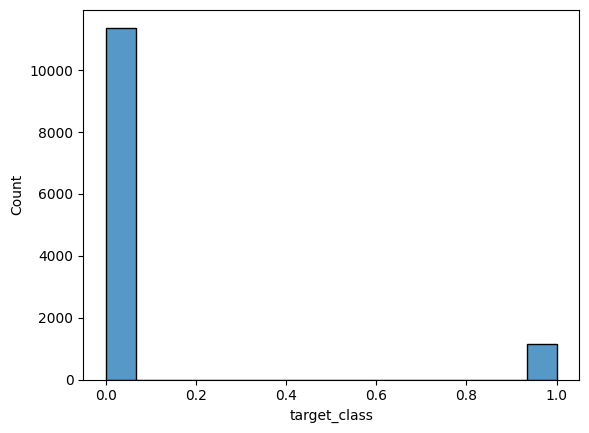

In [27]:
sns.histplot(x=train['target_class'])
train['target_class'].value_counts()

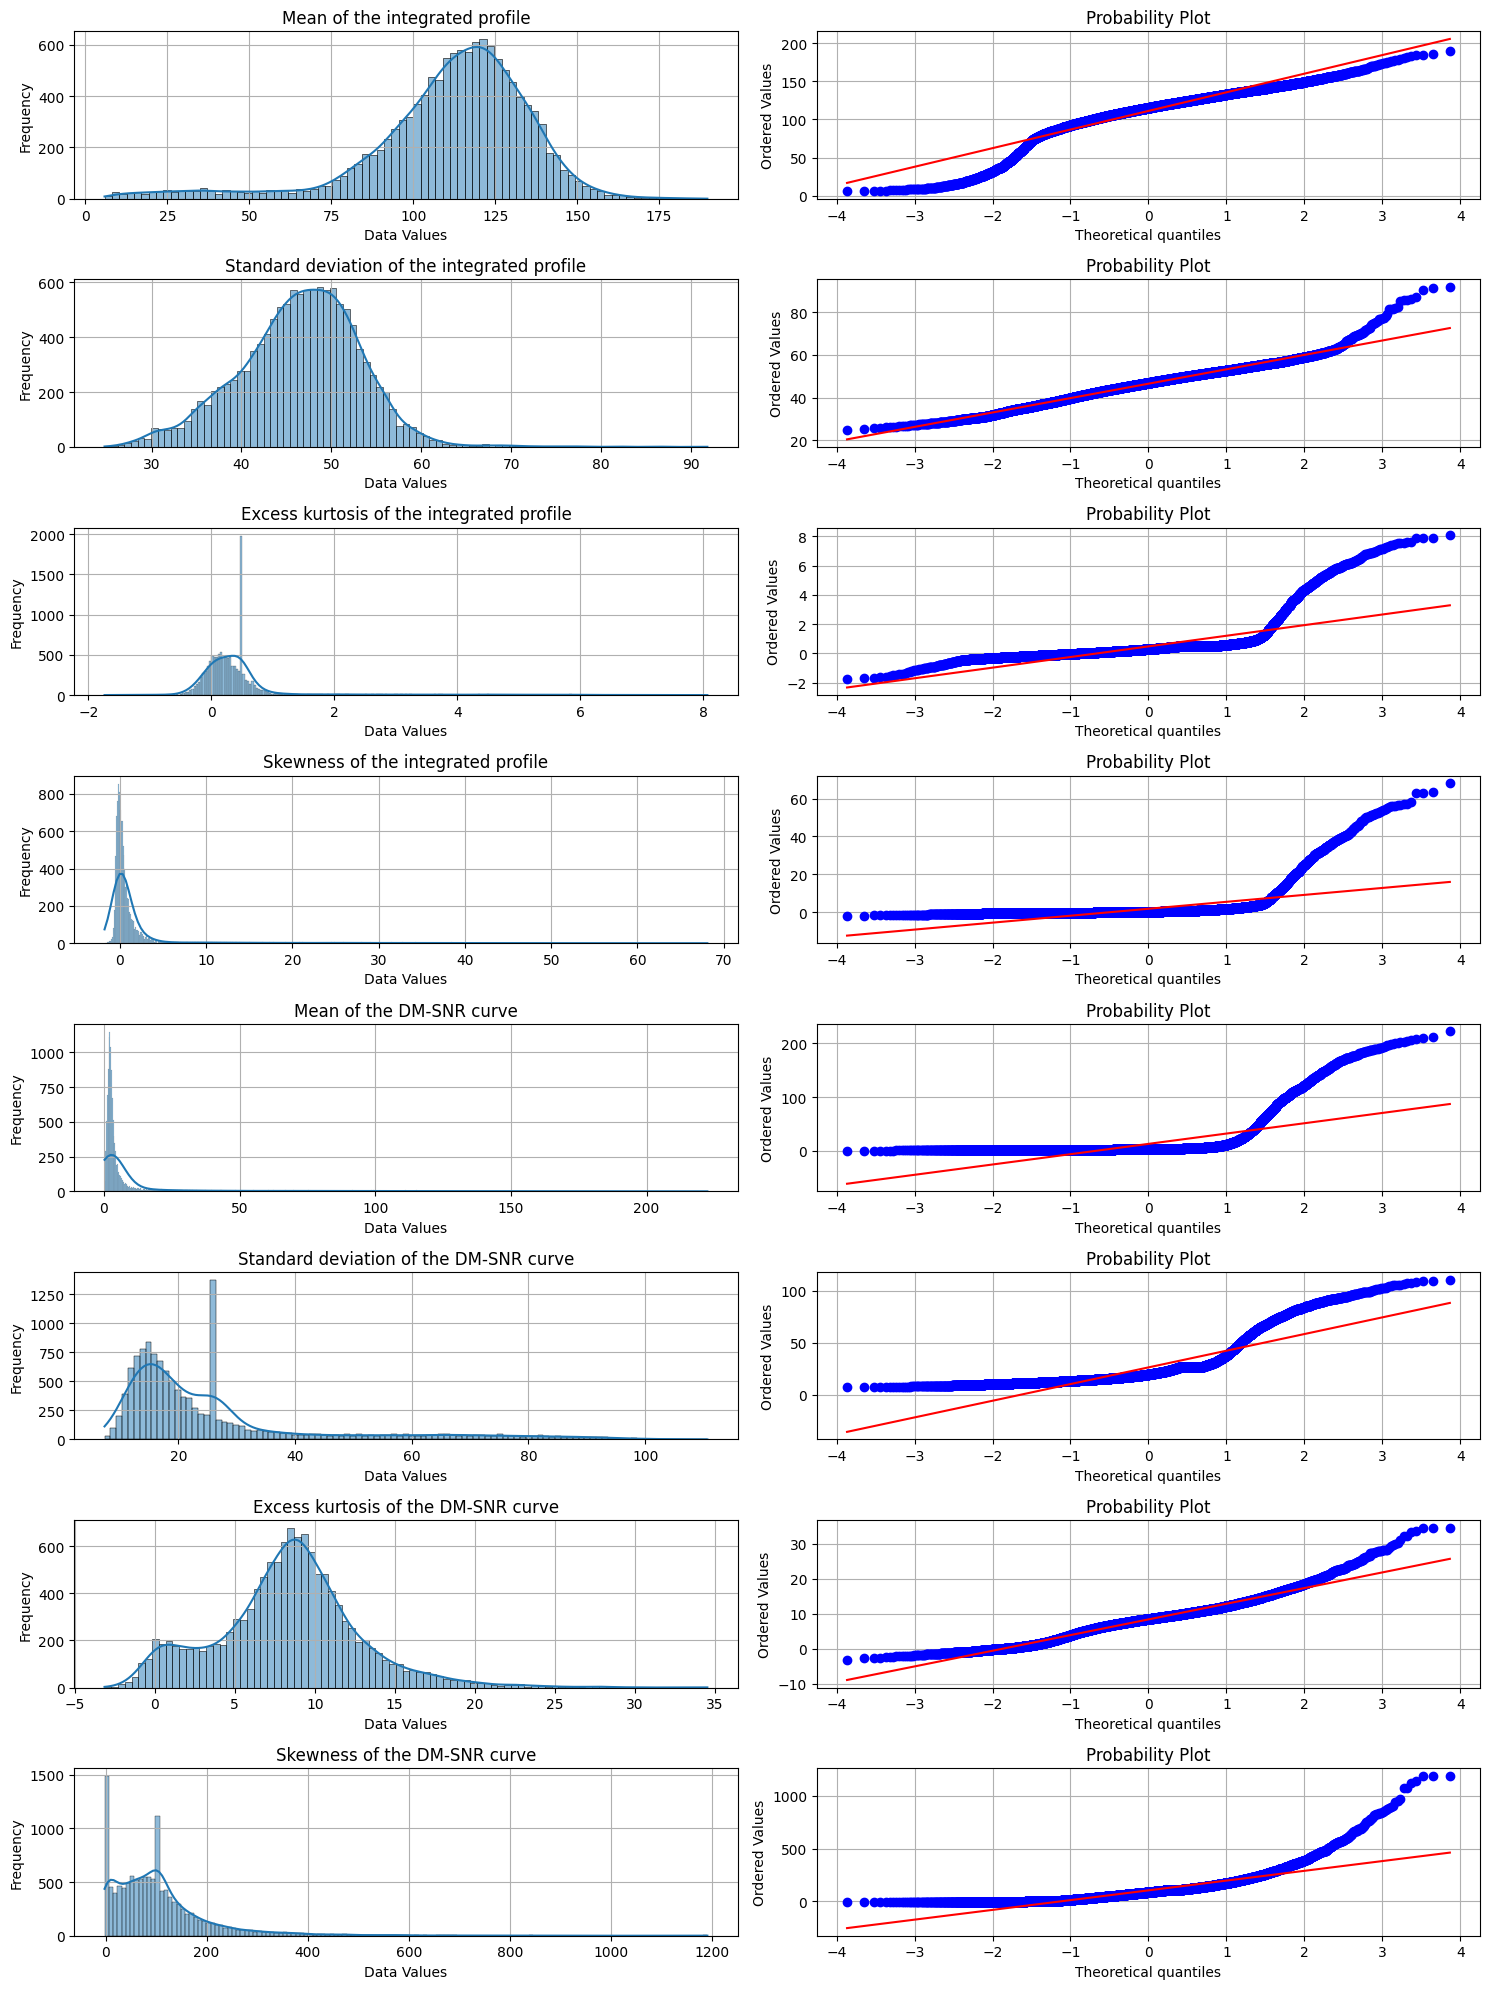

In [28]:
import seaborn as sns
from scipy import stats

fig, axs = plt.subplots(8, 2, figsize=(15, 20))
axs = axs.flatten()

for i, col in enumerate(train.columns[train.columns != "target_class"]) :
    sns.histplot(train[col], kde=True, ax=axs[i*2])
    axs[i*2].set_title(col)
    axs[i*2].set_xlabel('Data Values')
    axs[i*2].set_ylabel('Frequency')
    axs[i*2].grid(True)
    stats.probplot(train[col], plot=axs[i*2+1])
    axs[i*2+1].grid(True)

plt.tight_layout()
plt.show()

In [29]:
train["target_class"] = train["target_class"].astype(int, copy=True)

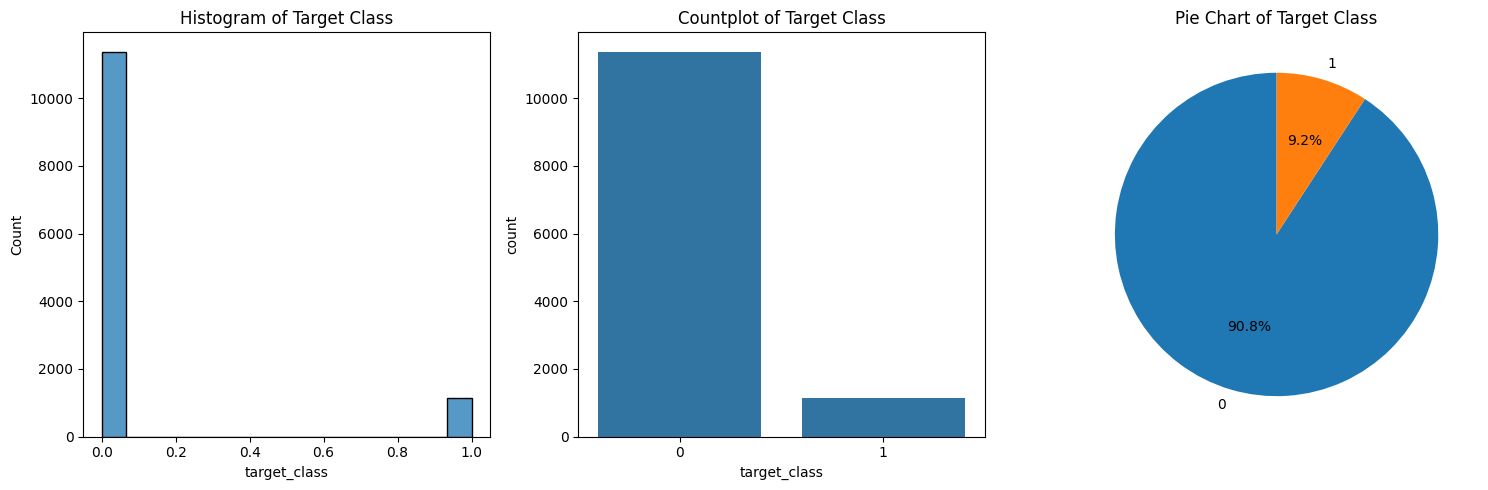

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogram
sns.histplot(train['target_class'], ax=axes[0])
axes[0].set_title('Histogram of Target Class')

# Countplot
sns.countplot(x='target_class', data=train, ax=axes[1])
axes[1].set_title('Countplot of Target Class')

# Pie chart
target_counts = train['target_class'].value_counts()
axes[2].pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90)
axes[2].set_title('Pie Chart of Target Class')

plt.tight_layout()
plt.show()

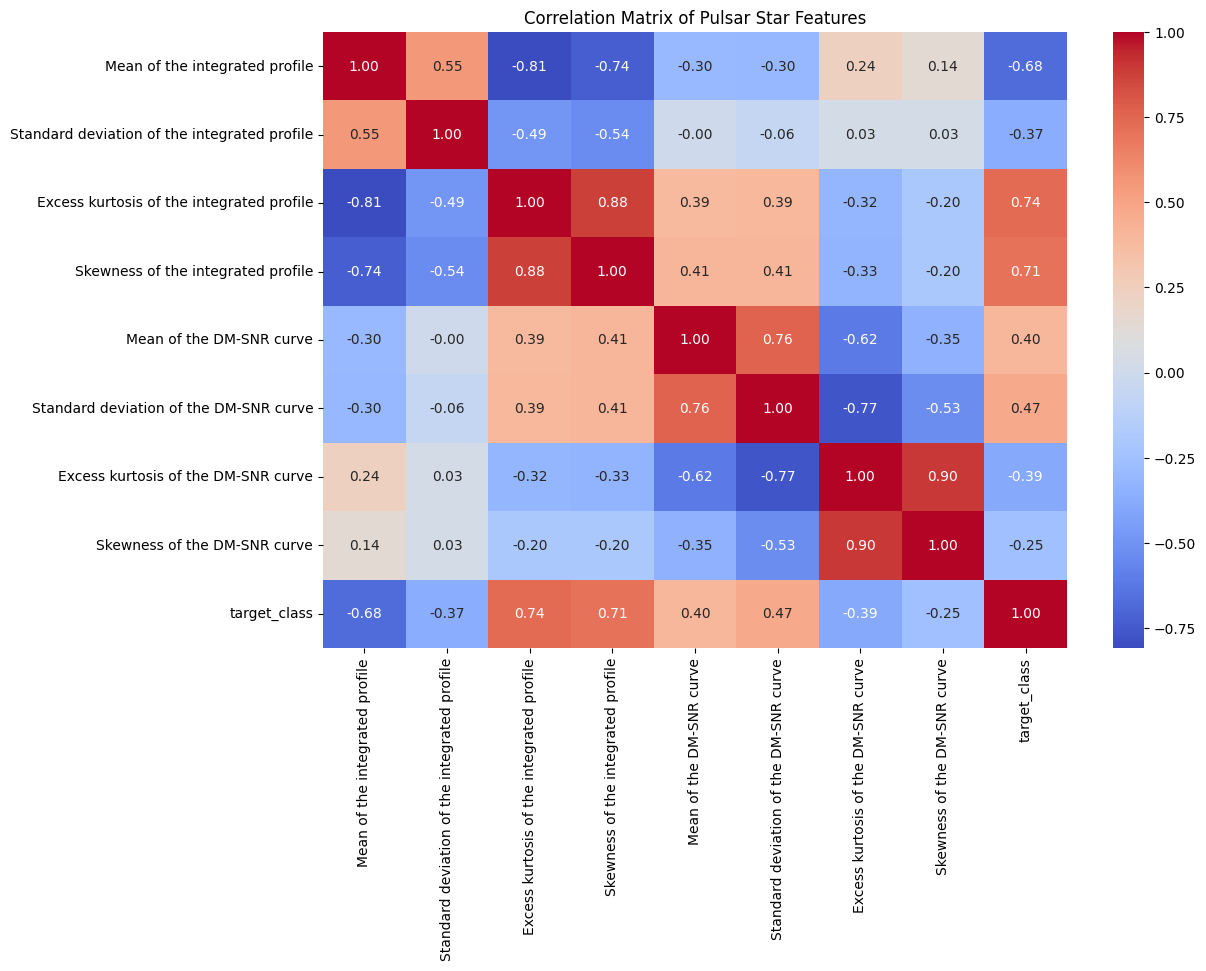

In [64]:
correlation_matrix = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Pulsar Star Features')
plt.show()

In [65]:
X = train.drop('target_class', axis=1)
y = train['target_class']

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation data using the same scaler
X_valid_scaled = scaler.transform(X_valid)

In [66]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((10022, 8), (10022,), (2506, 8), (2506,))

In [67]:
X_train_scaled[:5]

array([[-0.01479984,  0.00807199, -0.00154756, -0.26713777, -0.32745919,
        -0.36190145, -0.0602755 ,  0.00442823],
       [ 0.65661187, -0.93594453, -0.00154756, -0.1825406 , -0.26915543,
        -0.14914815, -0.54748013, -0.6435092 ],
       [ 0.51949045,  0.07737066, -0.41033388, -0.26107441, -0.38413404,
        -0.62708152,  1.02851759,  0.75181225],
       [-0.1350076 , -0.11730067, -0.09955769, -0.15962682, -0.36208758,
        -0.64788118,  0.46994311,  0.28074461],
       [ 0.83722554, -0.51573837, -0.5892599 , -0.2143498 , -0.3519771 ,
        -0.42979093,  0.20809211, -0.10398949]])

In [68]:
%pip install optuna

In [69]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_contour, plot_parallel_coordinate

In [70]:
# Define the objective function for Optuna
def objective(trial):
        # Calculate class weights
    class_weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train
    )

    # Convert class weights to a dictionary
    class_weight_dict = dict(enumerate(class_weights))

    # Choose the algorithm to tune
    classifier_name = trial.suggest_categorical('classifier', ['SVM', 'LogisticRegression', 'RandomForest', 'GradientBoosting'])

    if classifier_name == 'SVM':
        # SVM hyperparameters
        c = trial.suggest_float('C', 0.1, 100, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        model = SVC(class_weight=class_weight_dict ,C=c, kernel=kernel, gamma=gamma, random_state=42)

    elif classifier_name == 'RandomForest':
        # Random Forest hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])

        model = RandomForestClassifier(
            class_weight=class_weight_dict,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        )
    elif classifier_name == 'LogisticRegression':
        # Logistic Regression hyperparameters
        C = trial.suggest_float('C', 0.001, 10, log=True)
        solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'sag', 'saga'])

        model = LogisticRegression(class_weight=class_weight_dict ,C=C, solver=solver, random_state=42)

    elif classifier_name == 'GradientBoosting':
        # Gradient Boosting hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

    # Perform cross-validation and return the mean accuracy
    score = cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()
    return score

In [71]:
# Create a study and optimize it using CmaEsSampler
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, n_jobs=-1, show_progress_bar=True)

[I 2024-09-29 17:31:08,717] A new study created in memory with name: no-name-989ff59e-81e3-4758-b91c-ece4f2bd6f2e


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-09-29 17:31:09,152] Trial 0 finished with value: 0.9582915282873343 and parameters: {'classifier': 'LogisticRegression', 'C': 0.14793770976818188, 'solver': 'saga'}. Best is trial 0 with value: 0.9582915282873343.
[I 2024-09-29 17:31:09,336] Trial 2 finished with value: 0.9576926960207093 and parameters: {'classifier': 'LogisticRegression', 'C': 0.03534413258360671, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9582915282873343.
[I 2024-09-29 17:31:54,794] Trial 3 finished with value: 0.9678706340685883 and parameters: {'classifier': 'RandomForest', 'n_estimators': 262, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 10, 'bootstrap': False}. Best is trial 3 with value: 0.9678706340685883.
[I 2024-09-29 17:31:55,258] Trial 4 finished with value: 0.9587904705405114 and parameters: {'classifier': 'LogisticRegression', 'C': 0.4054712370159696, 'solver': 'sag'}. Best is trial 3 with value: 0.9678706340685883.
[I 2024-09-29 17:32:10,492] Trial 5 finished with valu

In [74]:
# Retrieve the best trial
best_trial = study.best_trial
print("Best trial parameters:", best_trial.params)
print("Best trial accuracy:", best_trial.value)

Best trial parameters: {'classifier': 'GradientBoosting', 'n_estimators': 262, 'learning_rate': 0.10273881605564328, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 10}
Best trial accuracy: 0.9780482136594814


In [75]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_C,params_bootstrap,params_classifier,params_gamma,params_kernel,params_learning_rate,params_max_depth,params_min_samples_leaf,params_min_samples_split,params_n_estimators,params_solver,state
0,0,0.958292,2024-09-29 17:31:08.749401,2024-09-29 17:31:09.151955,0 days 00:00:00.402554,0.147938,NaN,LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,saga,COMPLETE
1,1,0.977450,2024-09-29 17:31:08.751037,2024-09-29 17:32:45.015695,0 days 00:01:36.264658,NaN,NaN,GradientBoosting,NaN,NaN,0.047801,15.0,7.0,8.0,119.0,NaN,COMPLETE
2,2,0.957693,2024-09-29 17:31:09.175670,2024-09-29 17:31:09.335343,0 days 00:00:00.159673,0.035344,NaN,LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,liblinear,COMPLETE
3,3,0.967871,2024-09-29 17:31:09.355965,2024-09-29 17:31:54.793937,0 days 00:00:45.437972,NaN,False,RandomForest,NaN,NaN,NaN,9.0,10.0,4.0,262.0,NaN,COMPLETE
4,4,0.958790,2024-09-29 17:31:54.825729,2024-09-29 17:31:55.257937,0 days 00:00:00.432208,0.405471,NaN,LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sag,COMPLETE
5,5,0.972959,2024-09-29 17:31:55.308300,2024-09-29 17:32:10.491414,0 days 00:00:15.183114,NaN,True,RandomForest,NaN,NaN,NaN,14.0,6.0,6.0,141.0,NaN,COMPLETE
6,6,0.969467,2024-09-29 17:32:10.506993,2024-09-29 17:32:14.876223,0 days 00:00:04.369230,22.238554,NaN,SVM,auto,rbf,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
7,7,0.969467,2024-09-29 17:32:14.905464,2024-09-29 17:32:20.754293,0 days 00:00:05.848829,4.139552,NaN,SVM,auto,poly,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
8,8,0.978048,2024-09-29 17:32:20.773727,2024-09-29 17:35:21.219736,0 days 00:03:00.446009,NaN,NaN,GradientBoosting,NaN,NaN,0.102739,14.0,10.0,4.0,262.0,NaN,COMPLETE
9,9,0.958092,2024-09-29 17:32:45.036431,2024-09-29 17:32:45.230651,0 days 00:00:00.194220,0.166865,NaN,LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,liblinear,COMPLETE


In [76]:
study.trials_dataframe()['params_classifier'].value_counts()

,count
params_classifier,
GradientBoosting,6
LogisticRegression,4
SVM,3
RandomForest,2


In [77]:
study.trials_dataframe().groupby('params_classifier')['value'].mean()

,value
params_classifier,
GradientBoosting,0.976402
LogisticRegression,0.958217
RandomForest,0.970415
SVM,0.968303


In [78]:
# 1. Optimization History
plot_optimization_history(study).show()

In [79]:
# Get the best parameters from the Optuna study
best_params = study.best_params

# Choose the best classifier based on the best_params
classifier_name = best_params['classifier']

if classifier_name == 'SVM':
    model = SVC(**{k: v for k, v in best_params.items() if k != 'classifier'}, random_state=42)
elif classifier_name == 'RandomForest':
    model = RandomForestClassifier( **{k: v for k, v in best_params.items() if k != 'classifier'}, random_state=42)
elif classifier_name == 'LogisticRegression':
    model = LogisticRegression(**{k: v for k, v in best_params.items() if k != 'classifier'}, random_state=42)
elif classifier_name == 'GradientBoosting':
    model = GradientBoostingClassifier(**{k: v for k, v in best_params.items() if k != 'classifier'}, random_state=42)

# Train the model with the best parameters on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the validation data
y_pred = model.predict(X_valid_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_valid, y_pred)
print(f"Validation Accuracy with Best Parameters: {accuracy:.4f}")


Validation Accuracy with Best Parameters: 0.9796


In [80]:
Y_scores = model.predict_proba(X_valid_scaled)[:, 1]
Y_scores[:10]

array([1.58501226e-06, 1.04955429e-06, 2.50831481e-06, 9.56593677e-07,
       2.32599250e-01, 5.08501596e-02, 9.99998677e-01, 9.31421139e-04,
       3.57135958e-05, 1.30564261e-06])

In [81]:
fpr, tpr, thresholds = roc_curve(y_valid, Y_scores)
thresholds

array([           inf, 9.99999898e-01, 9.99967633e-01, 9.99965536e-01,
       9.91192795e-01, 9.84622451e-01, 9.78129625e-01, 9.69246129e-01,
       9.59702697e-01, 9.55955584e-01, 9.48066603e-01, 9.37976725e-01,
       9.24185734e-01, 9.22013696e-01, 7.90598598e-01, 6.05476984e-01,
       5.94397240e-01, 4.58684032e-01, 3.00101916e-01, 2.32599250e-01,
       1.97705560e-01, 1.30164939e-01, 1.02821063e-01, 8.11033287e-02,
       7.31464663e-02, 5.40588310e-02, 5.08501596e-02, 4.49744148e-02,
       3.71962566e-02, 2.97041670e-02, 2.22600654e-02, 9.66476519e-03,
       9.07053618e-03, 3.09908371e-03, 2.88756108e-03, 2.59817499e-03,
       2.52460214e-03, 2.34512608e-03, 2.32762709e-03, 1.93997983e-03,
       1.93286111e-03, 1.10328798e-03, 1.09554584e-03, 1.09267151e-03,
       1.03637572e-03, 4.63185641e-04, 4.45212499e-04, 3.67832764e-04,
       3.62598745e-04, 2.36716936e-04, 2.30937156e-04, 2.11875681e-04,
       2.11683922e-04, 1.07409688e-04, 1.07244479e-04, 6.35695398e-05,
      

Text(0, 0.5, 'True Positive Rate')

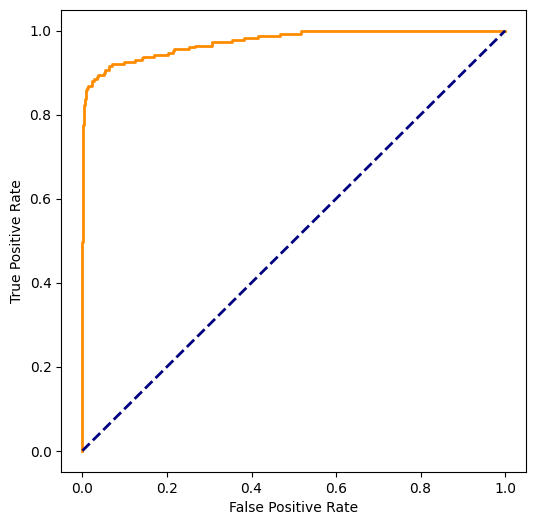

In [82]:
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [83]:
# prompt: use plotly for thresolds values for each fpr and tpr

import plotly.express as px
import plotly.graph_objects as go

# Create a DataFrame for the ROC curve data
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Thresholds': thresholds
})

# Create an interactive plot using Plotly
fig = go.Figure()

# Add ROC curve line
fig.add_trace(go.Scatter(x=roc_df['False Positive Rate'],
                         y=roc_df['True Positive Rate'],
                         mode='lines',
                         name='ROC Curve',
                         line=dict(color='blue', width=2)))

# Add diagonal line for reference (random classifier)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                         mode='lines',
                         name='Random Classifier',
                         line=dict(color='navy', dash='dash', width=2)))

# Add threshold markers
for i in range(len(thresholds)):
    fig.add_trace(go.Scatter(
        x=[fpr[i]],
        y=[tpr[i]],
        mode='markers+text',
        text=[f'Thresh: {thresholds[i]:.2f}'],
        textposition='top center',
        marker=dict(size=10, color='red')
    ))

# Update layout
fig.update_layout(
    title='ROC Curve with Thresholds',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    showlegend=True
)

# Show the figure
fig.show()


In [84]:

# You can define a function to calculate the optimal threshold based on your needs
def optimal_threshold(fpr, tpr, thresholds):
  """
  Calculates the optimal threshold based on the Youden's J statistic (J = sensitivity + specificity - 1)

  Args:
      fpr: False Positive Rate.
      tpr: True Positive Rate.
      thresholds: Threshold values.

  Returns:
      The optimal threshold.
  """
  J_statistic = tpr - fpr
  optimal_idx = np.argmax(J_statistic)
  return thresholds[optimal_idx]


optimal_thresh = optimal_threshold(fpr, tpr, thresholds)
print(f"Optimal Threshold: {optimal_thresh:.4f}")


Optimal Threshold: 0.0019


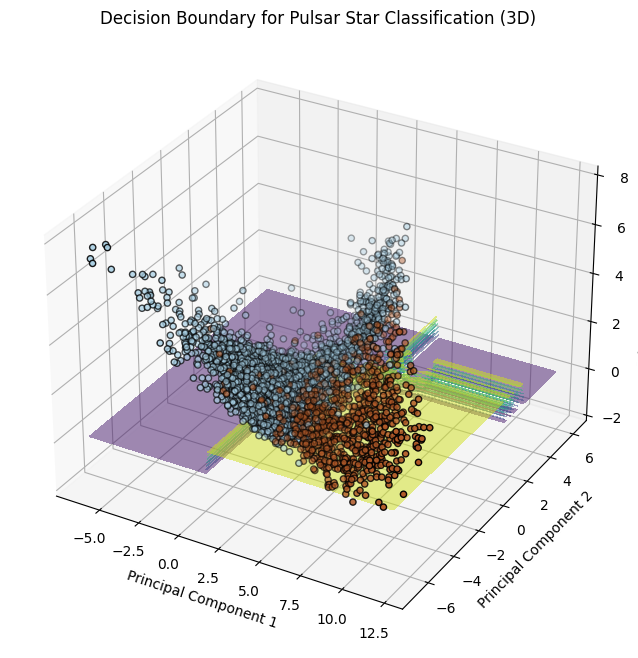

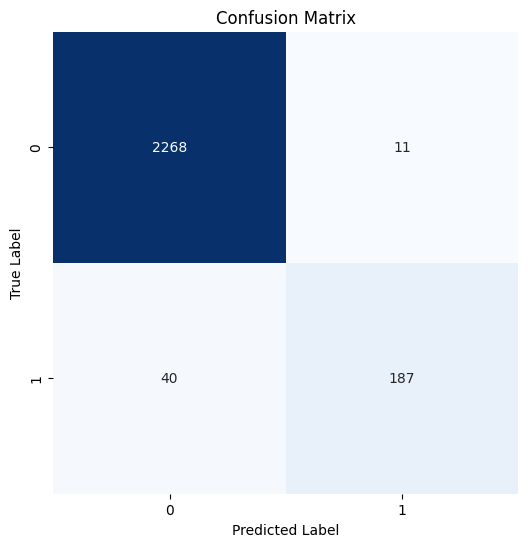

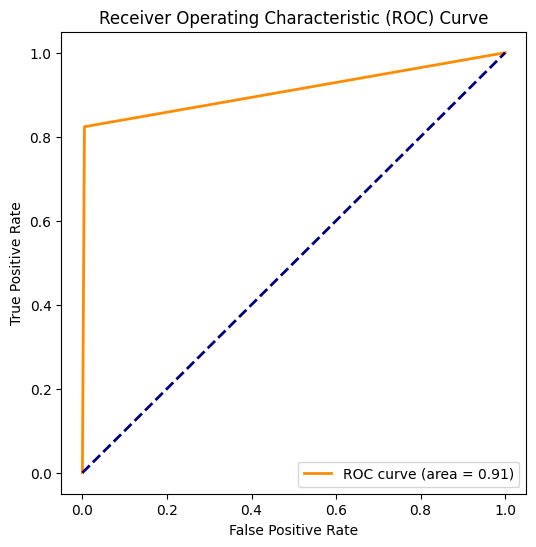

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2279
           1       0.94      0.82      0.88       227

    accuracy                           0.98      2506
   macro avg       0.96      0.91      0.93      2506
weighted avg       0.98      0.98      0.98      2506



In [85]:


# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Classification Report (you can print it directly)
print(classification_report(y_valid, y_pred))


In [86]:
# Predict on the test data
X_test = test.drop('target_class', axis=1)
y_test = test['target_class']

scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)

y_pred_test = model.predict(X_test_scaled)
y_pred_test[:30]

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0])

In [87]:
pulsar = []
neutron_star = []

for i in range(len(y_pred_test)):
  if y_pred_test[i] == 0:
    neutron_star.append(i)
    # print(f"Data point {i+1}: Neutron star ")
  else:
    pulsar.append(i)
    # print(f"Data point {i+1}: Pulsar")

print("Pulsars:",len(pulsar), "\nNeutron Stars:", len(neutron_star))


Pulsars: 438 
Neutron Stars: 4932


In [88]:
# prompt: draw decision boundry for 8 dmentional datasets into 3 dim

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of the data to 3 dimensions using PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)

# Fit the model again using the reduced data
model = RandomForestClassifier()
model.fit(X_train_pca, y_train)

# Create a meshgrid for the 3D plot
xx, yy = np.meshgrid(np.linspace(X_train_pca[:, 0].min(), X_train_pca[:, 0].max(), 100),
                     np.linspace(X_train_pca[:, 1].min(), X_train_pca[:, 1].max(), 100))

# Make predictions on the meshgrid
Z = model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
Z = Z.reshape(xx.shape)

# Create the interactive 3D plot using Plotly
fig = go.Figure()

# Add decision boundary surface
fig.add_trace(go.Surface(z=Z, x=xx, y=yy, opacity=0.5, colorscale='Viridis', name='Decision Boundary'))

# Plot the data points
fig.add_trace(go.Scatter3d(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    z=X_train_pca[:, 2],
    mode='markers',
    marker=dict(size=5, color=y_train, colorscale='Viridis', line=dict(width=0.5)),
    name='Data Points'
))

# Set axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    title='Decision Boundary for Pulsar Star Classification (3D)',
)

# Show the figure
fig.show()
